In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.environments import Env, Env_ActInf
from src.agents import AgentEWA, AgentQ
import src.helpers as F 

import pymdp
from pymdp import utils
from pymdp.agent import Agent as AgentActInf


sns.set_style('whitegrid')

In [3]:
# actinf agent
EPISODES = 2000
RUN_LENGTH = 1000

env_actinf = Env_ActInf(p_reward=0.7, context=1) # TODO


actinf_model = F.MDPGenerativeModel()
A, B, C, D = actinf_model.create_A(), actinf_model.create_B(), actinf_model.create_C(), actinf_model.create_D() # TODO pass the correct params
pA = F.parameterize_pA(A_base=A, scale = 1.0, prior_count=10e5)
agent_actinf = AgentActInf(A=A, pA=pA, B=B, C=C, D=D, modalities_to_learn=[1], lr_pA = 1.0, use_param_info_gain=True, action_selection='deterministic')

# agent_actinf.__dict__
returns_actinf = np.zeros([EPISODES, RUN_LENGTH])
choice_hist, belief_hist, qA_hist, context_hist = actinf_model.run_active_inference_with_learning(agent_actinf, env_actinf, T=RUN_LENGTH)


In [7]:
np.mean(context_hist)

0.477

In [3]:
# env = Env(payoff_structure=(0.6, 0.3, 0.1))
high_low_var = (1, 0, 0)
env = Env(payoff_structure=high_low_var)
env_actinf = Env_ActInf(p_reward=0.7, context=env.best_action) # TODO

EPISODES = 2000
RUN_LENGTH = 1000

""" arrays to hold returns """
# Q agents
returns_Q = np.zeros([EPISODES, RUN_LENGTH])
returns_Q_greedy = np.zeros([EPISODES, RUN_LENGTH])
returns_Q_smart = np.zeros([EPISODES, RUN_LENGTH])
returns_Q_social = np.zeros([EPISODES, RUN_LENGTH])

# EWA agents
returns_EWA = np.zeros([EPISODES, RUN_LENGTH])
returns_EWA_asoc = np.zeros([EPISODES, RUN_LENGTH])

# actinf agent - define generative model
actinf_model = F.MDPGenerativeModel()
A, B, C, D = actinf_model.create_A(), actinf_model.create_B(), actinf_model.create_C(), actinf_model.create_D() # TODO pass the correct params
returns_actinf = np.zeros([EPISODES, RUN_LENGTH])


""" simulation """

for episode in range(EPISODES):

    agentQ = AgentQ('A')
    agentQ_smart = AgentQ('C')
    agentQ_greedy = AgentQ("D", epsilon=0, is_social=False)
    agentQ_social = AgentQ("D", epsilon=0, is_social=True)

    agentEWA = AgentEWA('B', is_social=True)
    agentEWA_asoc = AgentEWA('B', sigma=0, is_social=False)

    agent_actinf = AgentActInf(A=A, B=B, C=C, D=D)
    # run actinf sim
    actinf_model.run_active_inference_with_learning(agent_actinf, env_actinf, T=RUN_LENGTH)
    

    env.reset()

    for i in range(RUN_LENGTH):
        actions_this_round = {}
        actions_last_round =  None if (i == 0) else env.history[-1] # TODO?

        if i % 250 == 0: 
            env.switch()
            agentQ_smart.reset_Qvals()

        for agent in (agentQ, agentQ_greedy, agentQ_smart, agentEWA, agentEWA_asoc, agentQ_social):
            choice = agent.choose_action(context=actions_last_round)
            actions_this_round[agent.id] = choice
            reward, is_optimal = env.return_rewards(choice)
            agent.update_state(reward, is_optimal)
            agent.update_Qvals(choice, reward)

        env.history.append(actions_this_round)
    

    returns_Q[episode, :] = agentQ.payoffs
    returns_Q_greedy[episode, :] = agentQ_greedy.payoffs
    returns_Q_smart[episode, :] = agentQ_smart.payoffs
    returns_Q_social[episode, :] = agentQ_social.payoffs
    returns_EWA[episode, :] = agentEWA.payoffs
    returns_EWA_asoc[episode, :] = agentEWA_asoc.payoffs



In [4]:
for ret in (returns_Q, returns_Q_greedy, returns_Q_smart, returns_Q_social, returns_EWA, returns_EWA_asoc):
    print(np.mean(ret))

0.499732
0.5
0.749422
0.5610275
0.550924
0.5081975


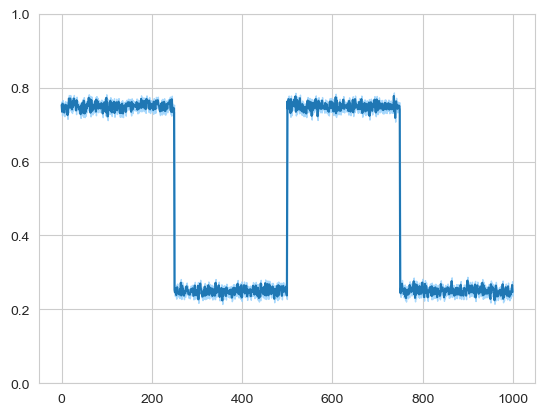

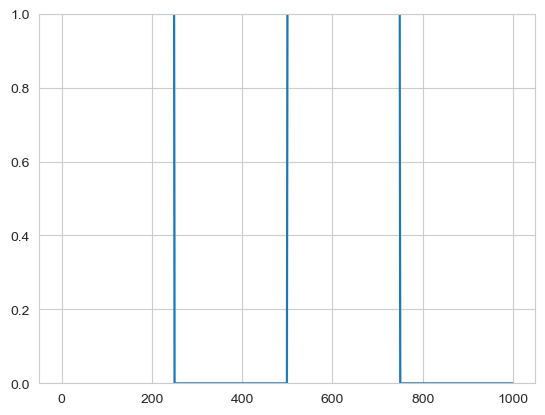

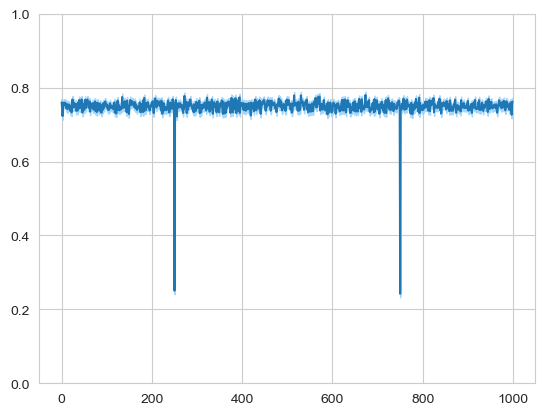

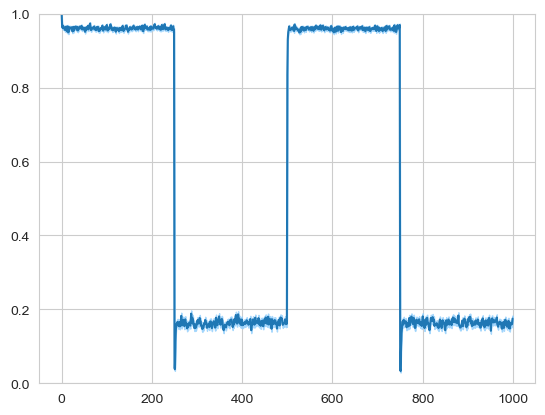

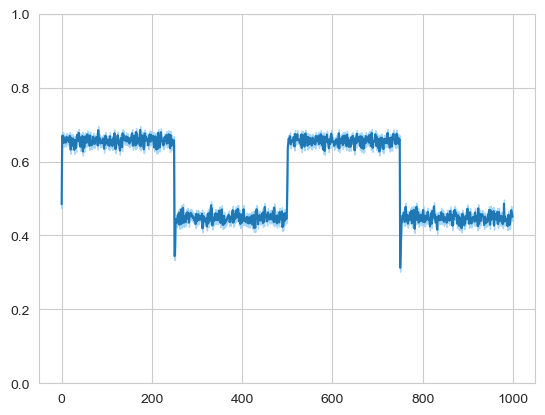

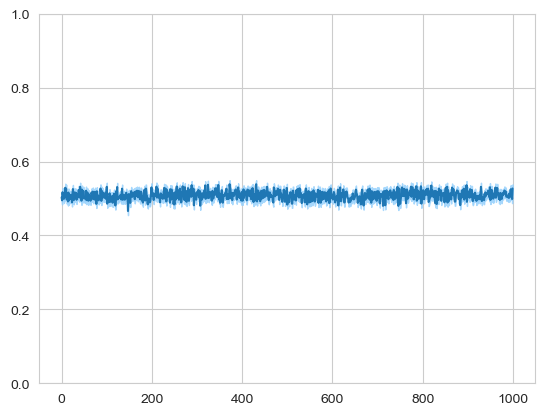

In [5]:
F.plot_returns(returns_Q)
F.plot_returns(returns_Q_greedy)
F.plot_returns(returns_Q_smart)
F.plot_returns(returns_Q_social)
F.plot_returns(returns_EWA)
F.plot_returns(returns_EWA_asoc)

### Q-learning

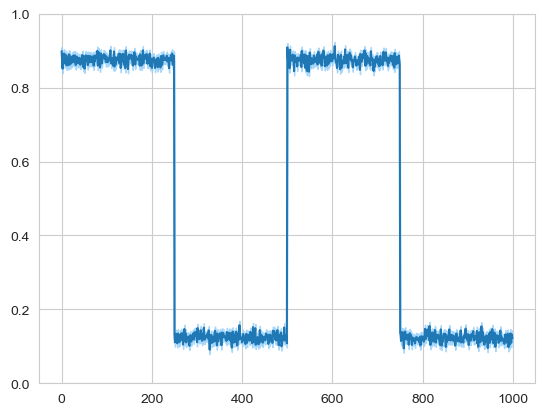

In [4]:
F.plot_returns(returns_Q)

### EWA

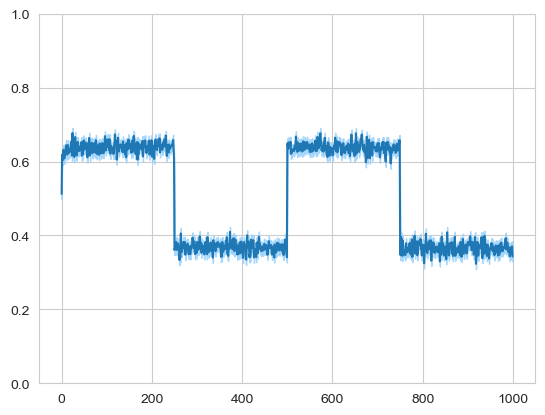

In [5]:
F.plot_returns(returns_EWA)


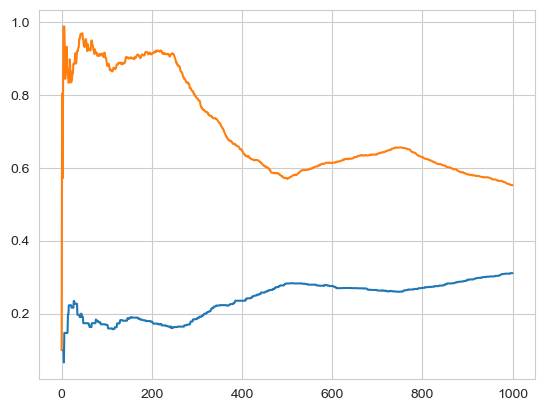

In [5]:
plt.plot(agentQ.Q_vals)

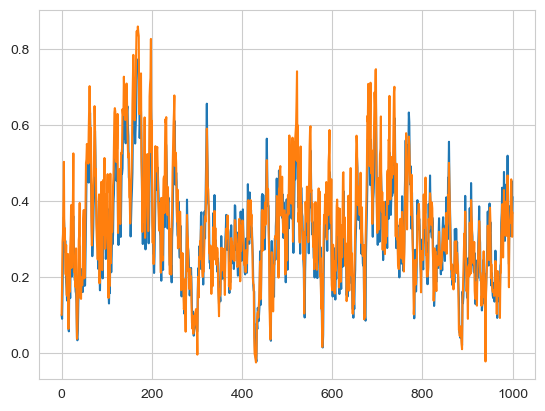

In [6]:
plt.plot(agentEWA.Q_vals)

In [ ]:
print(np.mean(agentEWA1.correct), np.mean(agentQ1.correct) )

0.501 0.476


446.84698492019896 441.1802904727145


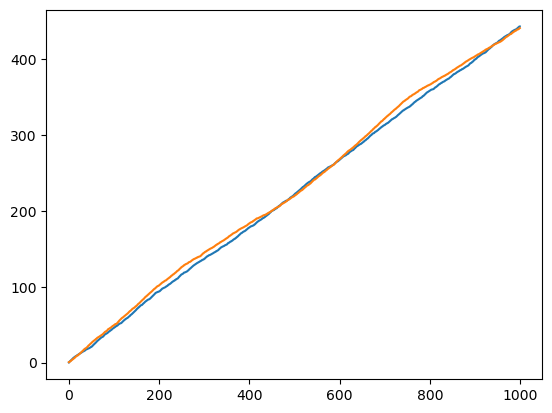

In [ ]:
# plt.plot(np.cumsum(agentEWA1.payoffs))
plt.plot(np.cumsum(agentEWA2.payoffs))
plt.plot(np.cumsum(agentQ1.payoffs))

print(np.sum(agentEWA1.payoffs),np.sum(agentQ1.payoffs))